In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import ceil, floor
from datetime import datetime 
torch.manual_seed(123)

# Model definition

In [14]:
# Model definition
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Training on device {device}.")

class LocalizationModel(nn.Module):
    def __init__(self, num_classes=10):
        super(LocalizationModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 12 * 15, 128)  # Adjusted for input size 48x60
        self.fc2 = nn.Linear(128, num_classes + 5)  # C + 5 outputs

    def forward(self, x):
        x = F.relu(self.conv1(x))  # [batch_size, 32, 48, 60]
        x = F.max_pool2d(x, 2)  # [batch_size, 32, 24, 30]
        x = F.relu(self.conv2(x))  # [batch_size, 64, 24, 30]
        x = F.max_pool2d(x, 2)  # [batch_size, 64, 12, 15]
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, 64 * 12 * 15]
        x = F.relu(self.fc1(x))  # [batch_size, 128]
        x = self.fc2(x)  # [batch_size, num_classes + 5]
        return x
    
# Making and improved model for evaluating.
class ImprovedLocalizationModel(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedLocalizationModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 6 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_pc = nn.Linear(128, 1)  # Output for pc (object presence)
        self.fc_bbox = nn.Linear(128, 4)  # Output for [x, y, w, h]
        self.fc_classes = nn.Linear(128, num_classes)  # Output for [c1, c2, ..., c10]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch_size, 32, 24, 30]
        x = self.pool(F.relu(self.conv2(x)))  # [batch_size, 64, 12, 15]
        x = self.pool(F.relu(self.conv3(x)))  # [batch_size, 128, 6, 7]
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, 128 * 6 * 7]
        x = F.relu(self.fc1(x))  # [batch_size, 256]
        x = F.relu(self.fc2(x))  # [batch_size, 128]
        
        # Output all components
        pc = torch.sigmoid(self.fc_pc(x))  # [batch_size, 1]
        bbox = self.fc_bbox(x)  # [batch_size, 4]
        classes = self.fc_classes(x)  # [batch_size, num_classes]
        
        # Concatenate all outputs
        output = torch.cat([pc, bbox, classes], dim=1)  # [batch_size, 1 + 4 + num_classes]
        return output
    

torch.manual_seed(123)
model = LocalizationModel().to(device)
torch.manual_seed(123)
improved_model = ImprovedLocalizationModel().to(device)

Training on device cuda.


## Localization


In [15]:
def localization_loss(y_pred, y_true):
    # Extract components from y_pred (has format [pc, x, y, w, h, c1, c2, ..., c10])
    pred_pc = y_pred[:, 0]
    pred_bbox = y_pred[:, 1:5]  # [x, y, w, h]
    pred_classes = y_pred[:, 5:]  # [c1, c2, ..., c10]
    
    # Extract components from y_true (has format [pc, x, y, w, h, c])
    true_pc = y_true[:, 0]
    true_bbox = y_true[:, 1:5]  # [x, y, w, h]
    true_class = y_true[:, 5].long()  # Convert class index to long
    
    # Detection loss (binary cross entropy with logits)
    detection_loss = F.binary_cross_entropy_with_logits(pred_pc, true_pc)
    
    # Calculate bbox loss and classification loss only when an object is present
    def when_object_present():
        # Bounding box loss (MSE)
        bbox_loss = F.mse_loss(pred_bbox, true_bbox)
        
        # Classification loss (cross entropy)
        class_loss = F.cross_entropy(pred_classes, true_class)
        
        return detection_loss + bbox_loss + class_loss
    
    # When no object is present, only use detection loss
    def when_no_object():
        return detection_loss
    
    # Use torch.where to conditionally compute the loss
    losses = torch.where(
        true_pc.bool(),
        when_object_present(),
        when_no_object()
    )
    
    # Return the mean loss across the batch
    return losses.mean()



### Load data and preprocessing

In [16]:
def load_data():
    # Load the datasets
    train_dataset = torch.load('data/localization_train.pt')
    val_dataset = torch.load('data/localization_val.pt')
    test_dataset = torch.load('data/localization_test.pt')

    # Ensure it's a TensorDataset
    print(f"Train dataset type: {type(train_dataset)}")
    print(f"Validation dataset type: {type(val_dataset)}")
    print(f"Test dataset type: {type(test_dataset)}")

    # Unpack tensors from TensorDataset
    X_train, y_train = train_dataset.tensors
    X_val, y_val = val_dataset.tensors
    X_test, y_test = test_dataset.tensors

    # Print shapes
    print(f"Train images shape: {X_train.shape}, Train targets shape: {y_train.shape}")
    print(f"Validation images shape: {X_val.shape}, Validation targets shape: {y_val.shape}")
    print(f"Test images shape: {X_test.shape}, Test targets shape: {y_test.shape}")

    return X_train, y_train, X_val, y_val, X_test, y_test

# Load data
X_train, y_train, X_val, y_val, X_test, y_test = load_data()


Train dataset type: <class 'torch.utils.data.dataset.TensorDataset'>
Validation dataset type: <class 'torch.utils.data.dataset.TensorDataset'>
Test dataset type: <class 'torch.utils.data.dataset.TensorDataset'>
Train images shape: torch.Size([59400, 1, 48, 60]), Train targets shape: torch.Size([59400, 6])
Validation images shape: torch.Size([6600, 1, 48, 60]), Validation targets shape: torch.Size([6600, 6])
Test images shape: torch.Size([11000, 1, 48, 60]), Test targets shape: torch.Size([11000, 6])


### Normalize Images

In [17]:
def normalize_images(images):
    mean = images.mean()
    std = images.std()
    transform = transforms.Normalize(mean, std)
    return transform(images)

X_train = normalize_images(X_train)
X_val = normalize_images(X_val)
X_test = normalize_images(X_test)

### Training

In [18]:
import torch
import torch.optim as optim

def train(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=64, lr=0.001, weight_decay=0.0):
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    torch.manual_seed(123)  # Jupyter bug fix
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    torch.manual_seed(123)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Use Adam optimizer with learning rate and weight decay
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_loss = float('inf')  # Track the best validation loss

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = localization_loss(output, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                output = model(images)
                val_loss += localization_loss(output, labels).item()

        val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss}')

        # Update best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss

    return best_val_loss 

# Hyperparameters
# Hyperparameters
learning_rates = [0.01, 0.001, 0.0001]
weight_decay_values = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128] 


# Variables to track the best hyperparameters
best_lr = None
best_weight_decay = None
best_batch_size = None
best_val_loss = float('inf')

# Training loop for hyperparameter tuning
for lr in learning_rates:
    for weight_decay in weight_decay_values:
        for batch_size in batch_sizes:
            print(f"Training with learning rate: {lr}, weight decay: {weight_decay}, batch size: {batch_size}")
            
            # Train the model and get the best validation loss
            val_loss = train(model, X_train, y_train, X_val, y_val, lr=lr, weight_decay=weight_decay, batch_size=batch_size)
            
            # Update best hyperparameters if this combination is better
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_lr = lr
                best_weight_decay = weight_decay
                best_batch_size = batch_size

print(f"Best hyperparameters: Learning Rate = {best_lr}, Weight Decay = {best_weight_decay}, Batch Size = {best_batch_size}, Validation Loss = {best_val_loss}")

Training with learning rate: 0.01, weight decay: 0.0001, batch size: 32
Epoch 1, Loss: 2.539268732070923, Validation Loss: 2.531227967589374
Epoch 2, Loss: 2.4778642654418945, Validation Loss: 2.5296566106271055
Epoch 3, Loss: 2.5939252376556396, Validation Loss: 2.528871421076825
Epoch 4, Loss: 2.3407301902770996, Validation Loss: 2.528856026377655
Epoch 5, Loss: 2.6911191940307617, Validation Loss: 2.527662317534
Epoch 6, Loss: 2.4070684909820557, Validation Loss: 2.5286094485849575
Epoch 7, Loss: 2.6106700897216797, Validation Loss: 2.5269874224916173
Epoch 8, Loss: 2.5247864723205566, Validation Loss: 2.5277085062386333
Epoch 9, Loss: 2.5487136840820312, Validation Loss: 2.527382046704131
Epoch 10, Loss: 2.4080679416656494, Validation Loss: 2.527191726481857
Training with learning rate: 0.01, weight decay: 0.0001, batch size: 64
Epoch 1, Loss: 1.035315752029419, Validation Loss: 1.620052864918342
Epoch 2, Loss: 1.765249490737915, Validation Loss: 1.4053813448319068
Epoch 3, Loss: 0

In [25]:
# Train the final model with the best hyperparameters
print("Training final model with best hyperparameters...")
train(model, X_train, y_train, X_val, y_val, lr=best_lr, weight_decay=best_weight_decay, batch_size=best_batch_size)
train(improved_model, X_train, y_train, X_val, y_val, lr=best_lr, weight_decay=best_weight_decay, batch_size=best_batch_size)

Training final model with best hyperparameters...
Epoch 1, Loss: 0.08922605216503143, Validation Loss: 0.8814823413672654
Epoch 2, Loss: 0.030780889093875885, Validation Loss: 0.9248895710649122
Epoch 3, Loss: 0.04334009811282158, Validation Loss: 0.9873783577251549
Epoch 4, Loss: 0.11389745026826859, Validation Loss: 1.0148796891244714
Epoch 5, Loss: 0.004934551194310188, Validation Loss: 0.9730254879608247
Epoch 6, Loss: 0.6022655367851257, Validation Loss: 1.0163999711689742
Epoch 7, Loss: 0.08025210350751877, Validation Loss: 1.0623076580428847
Epoch 8, Loss: 0.03440028056502342, Validation Loss: 1.0710374255111252
Epoch 9, Loss: 0.004797299392521381, Validation Loss: 1.0628245824201095
Epoch 10, Loss: 0.013493283651769161, Validation Loss: 1.1364923172094972
Epoch 1, Loss: 0.4185807704925537, Validation Loss: 0.631375032922496
Epoch 2, Loss: 0.9318699836730957, Validation Loss: 0.6095683291050547
Epoch 3, Loss: 0.36458492279052734, Validation Loss: 0.6387891884587237
Epoch 4, Loss

0.6095683291050547

### Predictions

In [20]:
def predict(model, image):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        output = model(image)
        pc_pred = torch.sigmoid(output[0, 0])
        bb_pred = output[0, 1:5]
        class_pred = torch.argmax(output[0, 5:])
        return pc_pred, bb_pred, class_pred
    
predict(model, X_test[0])
predict(improved_model, X_test[0])

(tensor(0.7311, device='cuda:0'),
 tensor([0.4031, 0.3310, 0.2352, 0.2950], device='cuda:0'),
 tensor(5, device='cuda:0'))

### Model selection and evaluation

In [28]:
def intersection(bb1, bb2):
    """
    Compute intersection between 2 bounding boxes in global frame of reference
    
    bb1, bb2: tensors of shape [x, y, w, h] where:
    - (x, y) is the center point
    - w is width
    - h is height
    """
    # Convert from center format to corner format
    bb1_x1 = bb1[0] - bb1[2]/2
    bb1_y1 = bb1[1] - bb1[3]/2
    bb1_x2 = bb1[0] + bb1[2]/2
    bb1_y2 = bb1[1] + bb1[3]/2
    
    bb2_x1 = bb2[0] - bb2[2]/2
    bb2_y1 = bb2[1] - bb2[3]/2
    bb2_x2 = bb2[0] + bb2[2]/2
    bb2_y2 = bb2[1] + bb2[3]/2
    
    # Calculate intersection coordinates
    x1 = max(bb1_x1, bb2_x1)
    y1 = max(bb1_y1, bb2_y1)
    x2 = min(bb1_x2, bb2_x2)
    y2 = min(bb1_y2, bb2_y2)
    
    # Check if there is an intersection
    if x2 < x1 or y2 < y1:
        return 0.0
    
    # Calculate intersection area
    return (x2 - x1) * (y2 - y1)

def IoU(bb1, bb2):
    """
    Compute IoU given 2 bounding boxes
    
    bb1, bb2: tensors of shape [x, y, w, h]
    """
    # Area of the first bounding box
    area_bb1 = bb1[2] * bb1[3]
    
    # Area of the second bounding box
    area_bb2 = bb2[2] * bb2[3]
    
    # Intersection area
    inter_area = intersection(bb1, bb2)
    
    # IoU calculation: intersection area / union area
    # Union = area_bb1 + area_bb2 - intersection area
    union_area = area_bb1 + area_bb2 - inter_area
    
    # Avoid division by zero
    if union_area < 1e-5:
        return 0.0
    
    return inter_area / union_area

def compute_IoU_localization(model, loader):
    """
    Compute IoU performance of the model on the given dataset
    """
    model.eval()
    total_iou = 0.0
    count = 0
    
    with torch.no_grad():
        for data, target in loader:
            # Normalize data
            data = normalize_images(data)
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Only consider images with objects
            mask = target[:, 0] == 1
            if not torch.any(mask):
                continue
                
            # For images with objects, calculate IoU
            pred_bboxes = output[mask, 1:5]
            true_bboxes = target[mask, 1:5]
            
            # Sigmoid for x, y and ensure w, h are positive
            pred_bboxes[:, 0:2] = torch.sigmoid(pred_bboxes[:, 0:2])
            pred_bboxes[:, 2:4] = torch.abs(pred_bboxes[:, 2:4])
            
            # Calculate IoU for each image
            for pred_bbox, true_bbox in zip(pred_bboxes, true_bboxes):
                total_iou += IoU(pred_bbox.cpu(), true_bbox.cpu())
                count += 1
    
    return total_iou / count if count > 0 else 0.0

def compute_accuracy_localization(model, loader):
    """
    Compute accuracy of the model on the given dataset
    """
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in loader:
            # Normalize data
            data = normalize_images(data)
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Only consider images with objects (pc=1)
            mask = target[:, 0] == 1
            if not torch.any(mask):
                continue
            
            # Get predictions for images with objects
            pred_pc = torch.sigmoid(output[mask, 0]) > 0.5
            pred_classes = torch.argmax(output[mask, 5:], dim=1)
            true_classes = target[mask, 5].long()
            
            # An image is correctly classified if pc is correct and class is correct
            correct_predictions = (pred_pc == 1) & (pred_classes == true_classes)
            correct += torch.sum(correct_predictions).item()
            total += mask.sum().item()
    
    return correct / total if total > 0 else 0.0

# Evaluation

In [29]:
def evaluate_model(model, loader, name="Model"):
    """
    Evaluate the model on the given data loader.
    
    Args:
        model: The model to evaluate.
        loader: DataLoader for the dataset to evaluate on.
        name: Name of the model for printing purposes.
    
    Returns:
        overall_loss: The average loss over the dataset.
        accuracy: The classification accuracy.
        iou: The average IoU over the dataset.
    """
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    correct = 0
    total = 0
    count = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Compute loss
            loss = localization_loss(output, target)
            total_loss += loss.item()
            
            # Only consider images with objects (pc=1)
            mask = target[:, 0] == 1
            if not torch.any(mask):
                continue
            
            # For images with objects, calculate IoU and accuracy
            pred_pc = torch.sigmoid(output[mask, 0]) > 0.5
            pred_bboxes = output[mask, 1:5]
            pred_classes = torch.argmax(output[mask, 5:], dim=1)
            
            true_bboxes = target[mask, 1:5]
            true_classes = target[mask, 5].long()
            
            # Sigmoid for x, y and ensure w, h are positive
            pred_bboxes[:, 0:2] = torch.sigmoid(pred_bboxes[:, 0:2])
            pred_bboxes[:, 2:4] = torch.abs(pred_bboxes[:, 2:4])
            
            # Calculate IoU for each image
            for pred_bbox, true_bbox in zip(pred_bboxes, true_bboxes):
                total_iou += IoU(pred_bbox.cpu(), true_bbox.cpu())
                count += 1
            
            # Calculate accuracy
            correct_predictions = (pred_pc == 1) & (pred_classes == true_classes)
            correct += torch.sum(correct_predictions).item()
            total += mask.sum().item()
    
    # Compute averages
    overall_loss = total_loss / len(loader)
    accuracy = correct / total if total > 0 else 0.0
    iou = total_iou / count if count > 0 else 0.0
    
    # Print results
    print(f"{name} Evaluation:")
    print(f"  Overall Loss: {overall_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  IoU: {iou:.4f}")
    
    return overall_loss, accuracy, iou



test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
overall_loss, accuracy, iou = evaluate_model(model, test_loader, name="Basic CNN")
overall_loss_improved, accuracy_improved, iou_improved = evaluate_model(improved_model, test_loader, name="Improved CNN")

Basic CNN Evaluation:
  Overall Loss: 1.0631
  Accuracy: 0.7634
  IoU: 0.1819
Improved CNN Evaluation:
  Overall Loss: 0.6090
  Accuracy: 0.9240
  IoU: 0.1582


In [31]:
def find_best_and_worst_predictions(model, dataset, n_samples=5):
    """
    Find examples of the best and worst predictions based on IoU scores.
    
    Args:
        model: Model to use for predictions
        dataset: Dataset to evaluate
        n_samples: Number of best/worst samples to return
        
    Returns:
        best_indices: Indices of best predictions
        worst_indices: Indices of worst predictions
    """
    model.eval()
    results = []
    
    # Define IoU function
    def compute_single_iou(bb1, bb2):
        # Convert from center format to corner format
        bb1_x1 = bb1[0] - bb1[2]/2
        bb1_y1 = bb1[1] - bb1[3]/2
        bb1_x2 = bb1[0] + bb1[2]/2
        bb1_y2 = bb1[1] + bb1[3]/2
        
        bb2_x1 = bb2[0] - bb2[2]/2
        bb2_y1 = bb2[1] - bb2[3]/2
        bb2_x2 = bb2[0] + bb2[2]/2
        bb2_y2 = bb2[1] + bb2[3]/2
        
        # Calculate intersection coordinates
        x1 = max(bb1_x1, bb2_x1)
        y1 = max(bb1_y1, bb2_y1)
        x2 = min(bb1_x2, bb2_x2)
        y2 = min(bb1_y2, bb2_y2)
        
        # Check if there is an intersection
        if x2 < x1 or y2 < y1:
            return 0.0
        
        # Calculate intersection area
        intersection_area = (x2 - x1) * (y2 - y1)
        
        # Calculate union area
        bb1_area = (bb1_x2 - bb1_x1) * (bb1_y2 - bb1_y1)
        bb2_area = (bb2_x2 - bb2_x1) * (bb2_y2 - bb2_y1)
        union_area = bb1_area + bb2_area - intersection_area
        
        # Calculate IoU
        if union_area < 1e-5:
            return 0.0
        return intersection_area / union_area
    
    # Evaluate each sample
    for i in range(len(dataset)):
        image, target = dataset[i]
        
        # Skip if no object present
        if target[0].item() < 0.5:
            continue
            
        # Get prediction
        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
        
        # Calculate IoU
        pred_pc = torch.sigmoid(output[0, 0]).item()
        pred_bbox = output[0, 1:5].cpu()
        pred_bbox[0:2] = torch.sigmoid(pred_bbox[0:2])
        pred_bbox[2:4] = torch.abs(pred_bbox[2:4])
        
        true_bbox = target[1:5]
        
        # Calculate IoU only if object is predicted
        if pred_pc > 0.5:
            iou = compute_single_iou(pred_bbox, true_bbox)
            pred_class = torch.argmax(output[0, 5:]).item()
            true_class = int(target[5].item())
            
            # Store result
            results.append({
                'index': i,
                'iou': iou,
                'pred_class': pred_class,
                'true_class': true_class,
                'class_correct': pred_class == true_class
            })
    
    # Sort results by IoU
    results = sorted(results, key=lambda x: x['iou'])
    
    # Get worst predictions (lowest IoU)
    worst_indices = [r['index'] for r in results[:n_samples]]
    
    # Get best predictions (highest IoU)
    best_indices = [r['index'] for r in results[-n_samples:][::-1]]
    
    return best_indices, worst_indices

def plot_images_with_bboxes(model, dataset, indices=None, num_images=5):
    """
    Plot images with true and predicted bounding boxes and labels.
    
    Args:
        model: The model to use for predictions.
        dataset: The dataset (TensorDataset) containing images and labels.
        indices: Optional list of specific indices to plot. If None, first num_images will be used.
        num_images: Number of images to plot.
    """
    model.eval()
    
    # Define class names (assuming 10 classes)
    class_names = [f"Class {i}" for i in range(10)]
    
    # Select indices to plot
    if indices is None:
        indices = range(min(num_images, len(dataset)))
    else:
        # Ensure we dont exceed the length of the dataset
        indices = indices[:min(len(indices), len(dataset))]
        num_images = len(indices)
    
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    if num_images == 1:
        axes = [axes]  # Make it iterable if there only one subplot
    
    for i, idx in enumerate(indices):
        image, target = dataset[idx]
        
        # Normalize image if needed
        norm_image = image.clone()
        
        # Forward pass
        norm_image = norm_image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(norm_image)
        
        # Extract predictions
        pred_pc = torch.sigmoid(output[0, 0]).item()
        pred_bbox = output[0, 1:5].cpu()
        # Apply sigmoid to x, y coordinates (0-1 range) and abs to ensure w, h are positive
        pred_bbox[0:2] = torch.sigmoid(pred_bbox[0:2])
        pred_bbox[2:4] = torch.abs(pred_bbox[2:4])
        pred_class = torch.argmax(output[0, 5:]).item()
        
        # Extract true values
        true_pc = target[0].item()
        true_bbox = target[1:5].cpu()
        true_class = int(target[5].item())
        
        # Convert image to numpy for display
        display_img = image.squeeze().cpu().numpy()
        
        # Plot the image
        ax = axes[i]
        ax.imshow(display_img, cmap='gray')
        ax.set_title(f"Image {idx}")
        
        # Calculate image dimensions
        height, width = display_img.shape
        
        # Convert normalized bbox coordinates to pixel coordinates
        def bbox_to_pixels(bbox):
            x, y, w, h = bbox
            # Convert to top-left format for Rectangle patch
            x_min = max(0, (x - w/2) * width)
            y_min = max(0, (y - h/2) * height)
            w_px = min(w * width, width - x_min)
            h_px = min(h * height, height - y_min)
            return x_min, y_min, w_px, h_px
        
        # Draw true bounding box
        if true_pc > 0.5:
            x_min, y_min, w_px, h_px = bbox_to_pixels(true_bbox)
            true_rect = patches.Rectangle(
                (x_min, y_min), w_px, h_px,
                linewidth=2, edgecolor='g', facecolor='none'
            )
            ax.add_patch(true_rect)
            ax.text(
                x_min, y_min - 5, 
                f'True: {class_names[true_class]}', 
                color='white', fontsize=10, 
                bbox=dict(facecolor='green', alpha=0.7, pad=1)
            )
        
        # Draw predicted bounding box
        if pred_pc > 0.5:
            x_min, y_min, w_px, h_px = bbox_to_pixels(pred_bbox)
            pred_rect = patches.Rectangle(
                (x_min, y_min), w_px, h_px,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(pred_rect)
            ax.text(
                x_min, max(0, y_min - 20), 
                f'Pred: {class_names[pred_class]} ({pred_pc:.2f})', 
                color='white', fontsize=10, 
                bbox=dict(facecolor='red', alpha=0.7, pad=1)
            )
        
        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    return fig

Visualizing random test samples with btoh model....


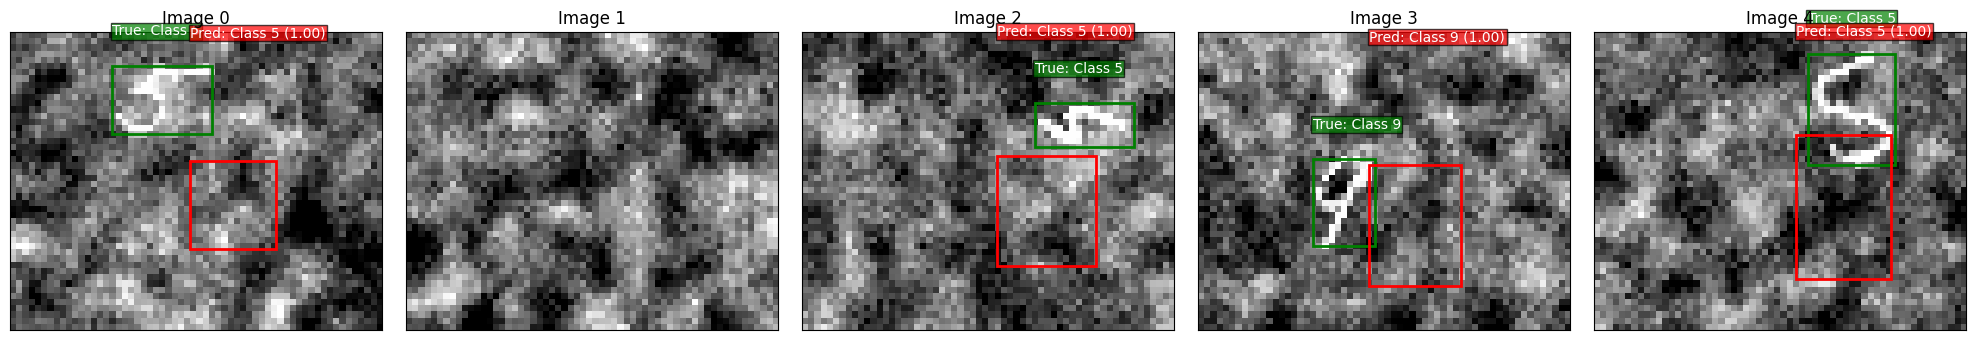

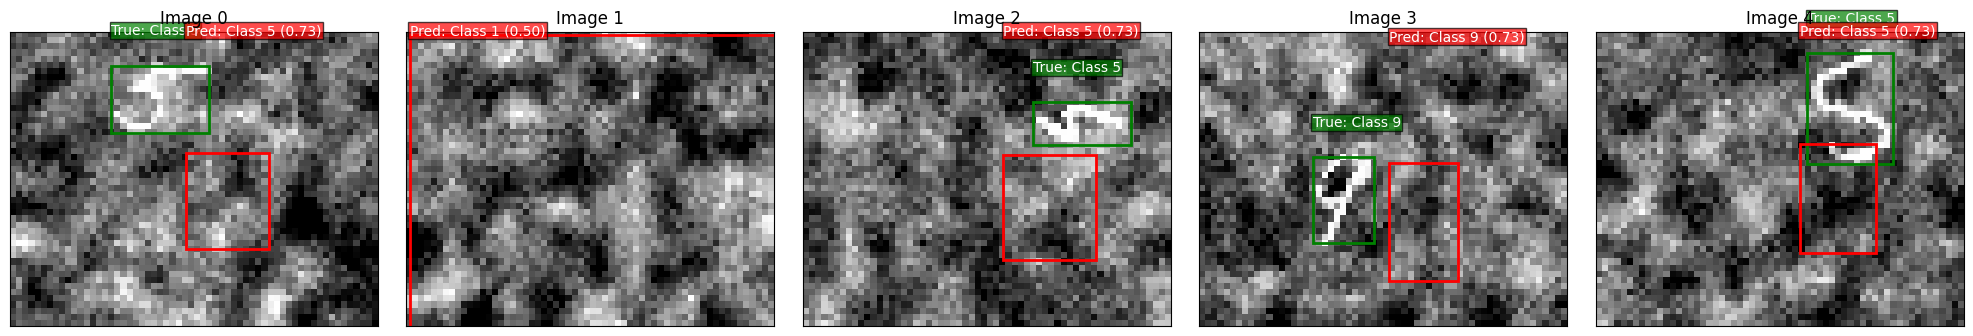

Finding best and worst predictions...
Best predictions:


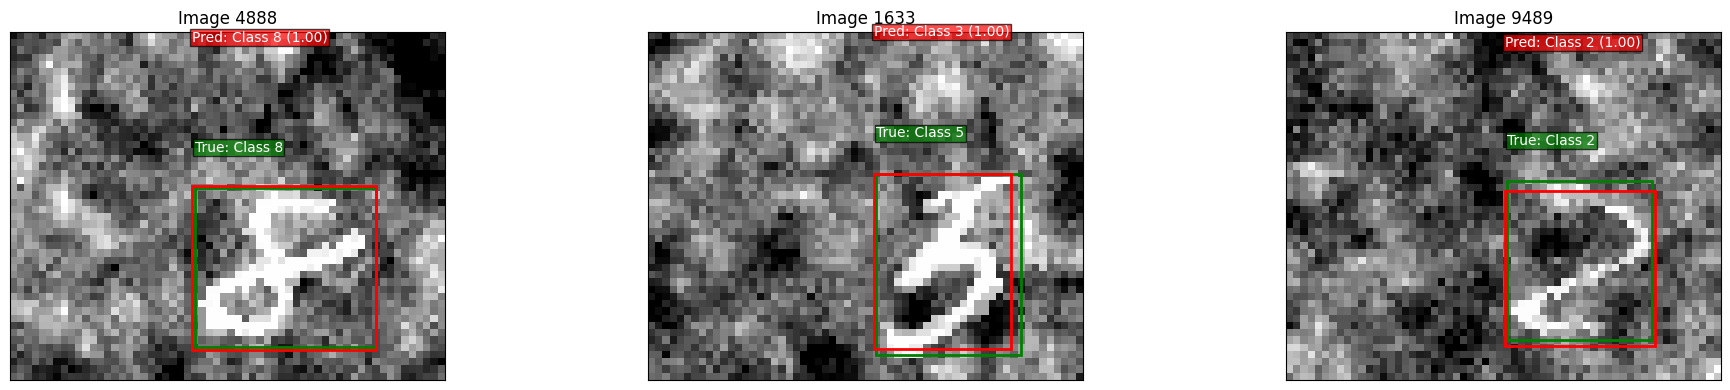

Worst predictions:


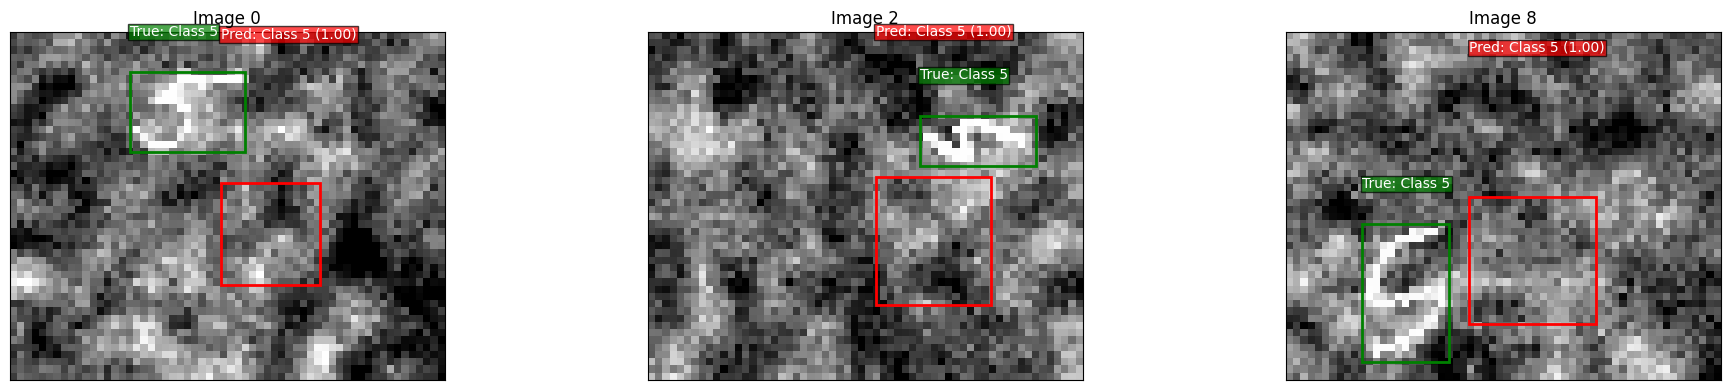

Finding best and worst predictions for improved model...
Best predictions (improved model):


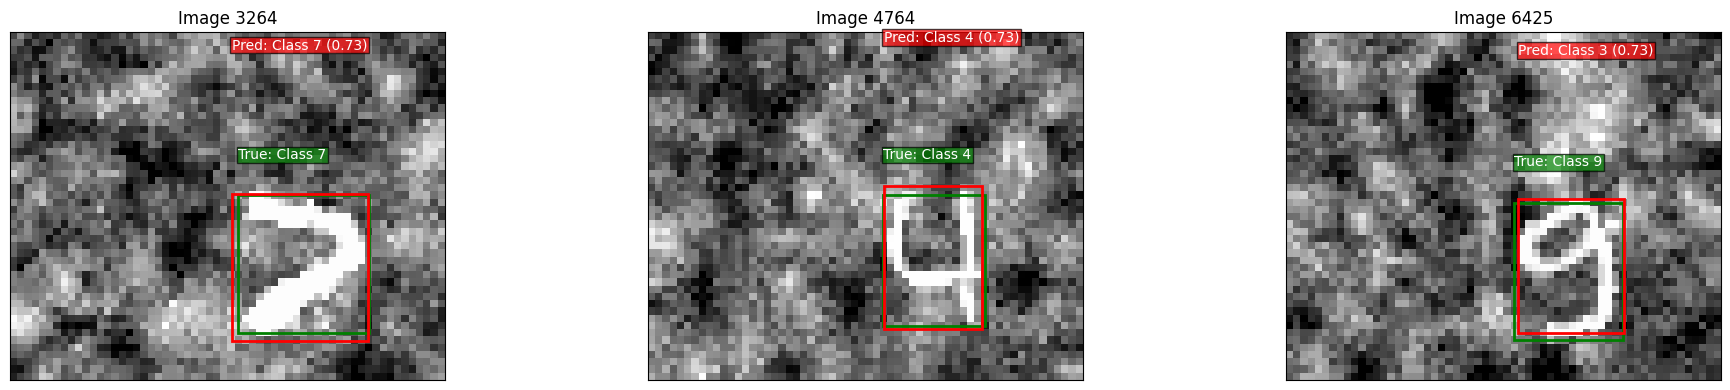

Worst predictions (improved model):


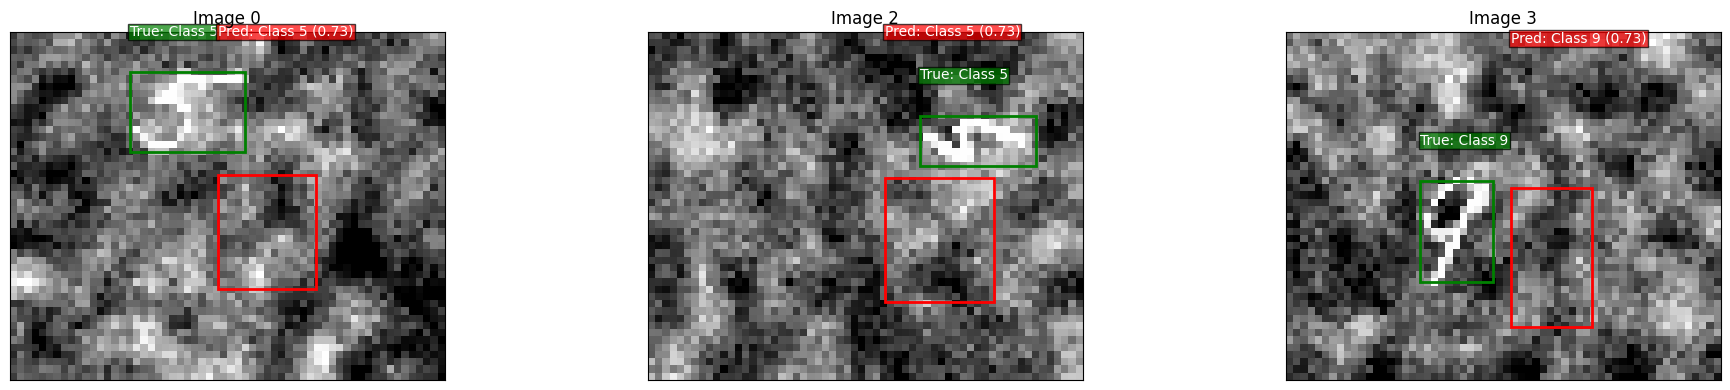

In [ ]:
def visualize_bounding_boxes():
    """
    Demonstrate the bounding box visualization functions.
    """
    print("Visualizing test samples with btoh model....")
    plot_images_with_bboxes(model, test_dataset, num_images=5)
    plot_images_with_bboxes(improved_model, test_dataset, num_images=5)
    
    
    print("Finding best and worst predictions...")
    best_indices, worst_indices = find_best_and_worst_predictions(model, test_dataset, n_samples=3)
    
    print("Best predictions:")
    plot_images_with_bboxes(model, test_dataset, indices=best_indices)
    
    print("Worst predictions:")
    plot_images_with_bboxes(model, test_dataset, indices=worst_indices)
    
    # Do the same for improved model
    print("Finding best and worst predictions for improved model...")
    best_indices_improved, worst_indices_improved = find_best_and_worst_predictions(improved_model, test_dataset, n_samples=3)
    
    print("Best predictions (improved model):")
    plot_images_with_bboxes(improved_model, test_dataset, indices=best_indices_improved)
    
    print("Worst predictions (improved model):")
    plot_images_with_bboxes(improved_model, test_dataset, indices=worst_indices_improved)

visualize_bounding_boxes()